<a href="https://colab.research.google.com/github/frohsch/MathSolverAI/blob/main/trl_dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # TRL과 DPO를 사용하여 VLM을 훈련하는 과정



In [ ]:
!pip install datasets
!pip install transformers
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manyli

In [ ]:
!git clone https://github.com/ZrrSkywalker/MathVerse.git

Cloning into 'MathVerse'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 202 (delta 64), reused 20 (delta 13), pack-reused 97 (from 1)
Receiving objects: 100% (202/202), 8.72 MiB | 18.56 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [ ]:
# install libraries
!pip install google-colab

# import libraries
from datasets import load_dataset
from google.colab import drive

# connect Google Drive
drive.mount('/content/drive')


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
Mounted at /content/drive


In [ ]:
from datasets import DatasetDict
from datasets import load_dataset

# 데이터셋 로드
dataset = load_dataset("AI4Math/MathVerse", 'testmini')

# 데이터프레임으로 변환
ds = dataset['testmini']

ds_train_devtest = ds.train_test_split(test_size=0.1, seed=42)

ds_splits = DatasetDict({
    'train': ds_train_devtest['train'],
    'test': ds_train_devtest['test']
})

train_ds = ds_train_devtest['train']
test_ds = ds_train_devtest['test']

print(ds_splits)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating testmini split:   0%|          | 0/3940 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval'],
        num_rows: 3546
    })
    test: Dataset({
        features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval'],
        num_rows: 394
    })
})


In [ ]:
rejected = ["foo"] * len(train_ds)
new_train_ds = train_ds.add_column("rejected", rejected)
print(new_train_ds)

Flattening the indices:   0%|          | 0/3546 [00:00<?, ? examples/s]

Dataset({
    features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval', 'rejected'],
    num_rows: 3546
})


In [ ]:
# from datasets import features
# from transformers import AutoProcessor

# processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

# def format(example):
#     # Prepare the input for the chat template
#     prompt = [
#         {
#             "role": "user",
#             "content": [{"type": "image"}, {"type": "text", "text": example["query_cot"]}],
#         },
#     ]
#     chosen = [
#         {
#             "role": "assistant",
#             "content": [{"type": "text", "text": example["answer"]}],
#         },
#     ]
#     rejected = [
#         {
#             "role": "assistant",
#             "content": [{"type": "text", "text": example["rejected"]}],
#         },
#     ]
#     # Apply the chat template
#     prompt = processor.apply_chat_template(prompt, tokenize=False)
#     chosen = processor.apply_chat_template(chosen, tokenize=False)
#     rejected = processor.apply_chat_template(rejected, tokenize=False)
#     # Resize the image to ensure it fits within the maximum allowable
#     # size of the processor to prevent OOM errors.
#     max_size = processor.image_processor.size["longest_edge"]
#     example["image"].thumbnail((max_size, max_size))
#     return {"images": [example["image"]], "prompt": prompt, "chosen": chosen, "rejected": rejected}

# # Apply the formatting function to the dataset,
# # remove columns to end up with only "images", "prompt", "chosen", "rejected" columns
# new_train_ds = new_train_ds.map(format, remove_columns=new_train_ds.column_names)

# # Make sure that the images are decoded, it prevents from storing bytes.
# # More info here https://github.com/huggingface/blog/pull/2148#discussion_r1667400478


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3546 [00:00<?, ? examples/s]

AttributeError: 'DatasetDict' object has no attribute 'features'

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(..., bf16=True)

TypeError: expected str, bytes or os.PathLike object, not ellipsis

In [ ]:
# LoRA 파라미터 얼마나 줄였는지 확인
# model.print_trainable_parameters()

In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.1 MB/s eta 0:00:00


In [ ]:
print(new_train_ds)

Dataset({
    features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval', 'rejected'],
    num_rows: 3546
})


In [ ]:
# dpo_idefics2-8b.py
from datasets import features, load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
from trl import DPOConfig, DPOTrainer
from peft import LoraConfig


def main():
    # Load the model and processor
    model = AutoModelForVision2Seq.from_pretrained("HuggingFaceM4/idefics2-8b", torch_dtype=torch.bfloat16)
    processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

    global new_train_ds

    def format(example):
        # Prepare the input for the chat template
        prompt = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": example["query_cot"]}]}]
        chosen = [{"role": "assistant", "content": [{"type": "text", "text": example["answer"]}]}]
        rejected = [{"role": "assistant", "content": [{"type": "text", "text": example["rejected"]}]}]
        # Apply the chat template
        prompt = processor.apply_chat_template(prompt, tokenize=False)
        chosen = processor.apply_chat_template(chosen, tokenize=False)
        rejected = processor.apply_chat_template(rejected, tokenize=False)
        # Resize the image to ensure it fits within the maximum allowable
        # size of the processor to prevent OOM errors.
        max_size = processor.image_processor.size["longest_edge"] // 2
        example["image"].thumbnail((max_size, max_size))
        return {"images": [example["image"]], "prompt": prompt, "chosen": chosen, "rejected": rejected}

    # Apply the formatting function to the dataset
    new_train_ds = new_train_ds.map(format, remove_columns=new_train_ds.column_names, num_proc=32)


    # Make sure that the images are decoded, it prevents from storing bytes.
    # More info here https://github.com/huggingface/blog/pull/2148#discussion_r1667400478
    f = new_train_ds.features
    f["images"] = features.Sequence(features.Image(decode=True))
    new_train_ds = new_train_ds.cast(f)

    # Train the model
    training_args = DPOConfig(
        output_dir="drive/MyDrive/idefics2-8b-dpo",
        bf16=True,
        gradient_checkpointing=True,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=32,
        num_train_epochs=1,
        dataset_num_proc=32,  # tokenization will use 32 processes
        dataloader_num_workers=32,  # data loading will use 32 workers
        logging_steps=10,
    )
    trainer = DPOTrainer(
        model,
        ref_model=None,  # not needed when using peft
        args=training_args,
        train_dataset=new_train_ds,
        tokenizer=processor,
        peft_config=LoraConfig(target_modules="all-linear"),
    )

    trainer.train()


if __name__ == "__main__":
    main()


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/3546 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3546 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:394: UserWarning: `max_length` is not set in the DPOConfig's init it will default to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:407: UserWarning: `max_prompt_length` is not set in the DPOConfig's init it will default to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:442: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Map (num_proc=32):   0%|          | 0/3546 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need 

Step,Training Loss
10,0.163000
20,0.000100
30,0.000000
40,0.000000
50,0.000000


In [ ]:
!mv idefics2-8b-dpo/ drive/MyDrive/

In [ ]:
print(new_train_ds)

Dataset({
    features: ['answer', 'query_cot', 'images'],
    num_rows: 3546
})


In [ ]:
print(ds)

Dataset({
    features: ['rejected', 'images', 'prompt', 'chosen'],
    num_rows: 3546
})


In [ ]:
print(dataset['testmini'])

Dataset({
    features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval'],
    num_rows: 3940
})


In [ ]:
ds = dataset['testmini']

523


523


Images


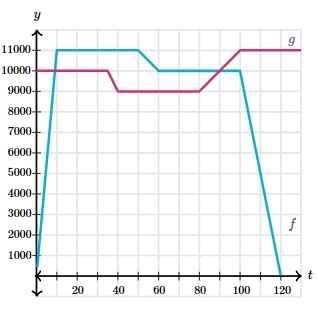

In [ ]:
#523
print(ds[2610]['problem_index'])
ds[2610]['image']

659


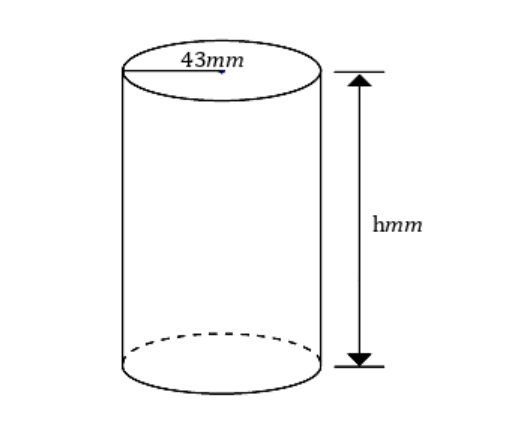

In [ ]:
#659
print(ds[3292]['problem_index'])
ds[3292]['image']

662


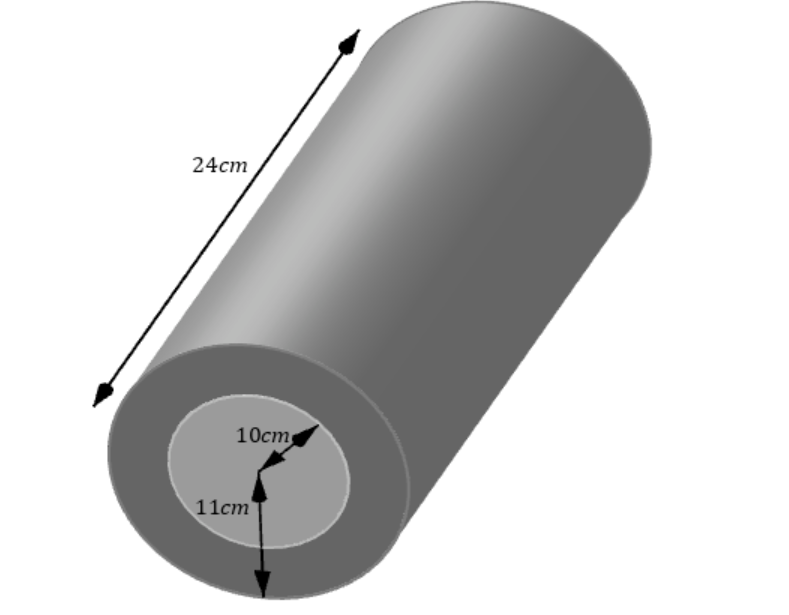

In [ ]:
#662
print(ds[3305]['problem_index'])
ds[3305]['image']

722


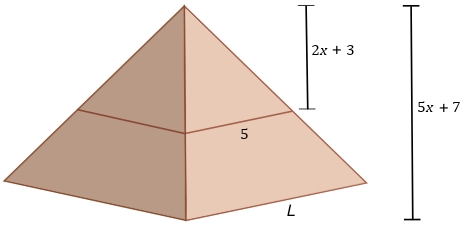

In [ ]:
#722
print(ds[3605]['problem_index'])
ds[3605]['image']

93


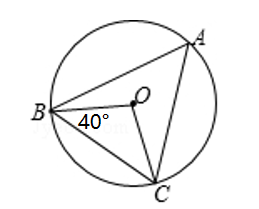

In [ ]:
#93
print(ds[463]['problem_index'])
ds[463]['image']

331


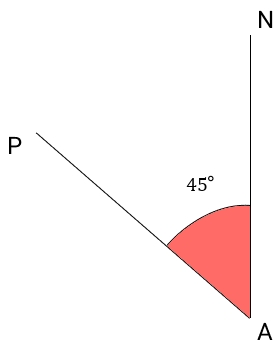

In [ ]:
#331
print(ds[1653]['problem_index'])
ds[1653]['image']

332


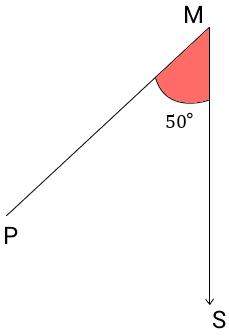

In [ ]:
#332
print(ds[1656]['problem_index'])
ds[1656]['image']

339


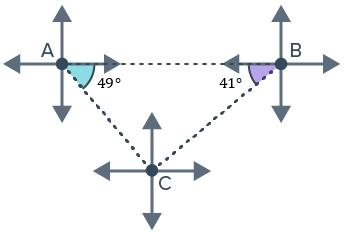

In [ ]:
#339
print(ds[1692]['problem_index'])
ds[1692]['image']

399


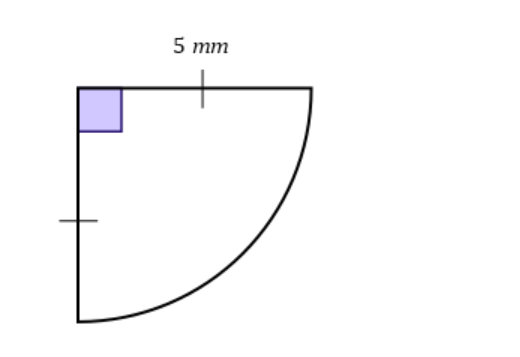

In [ ]:
#399
print(ds[1992]['problem_index'])
ds[1992]['image']

402


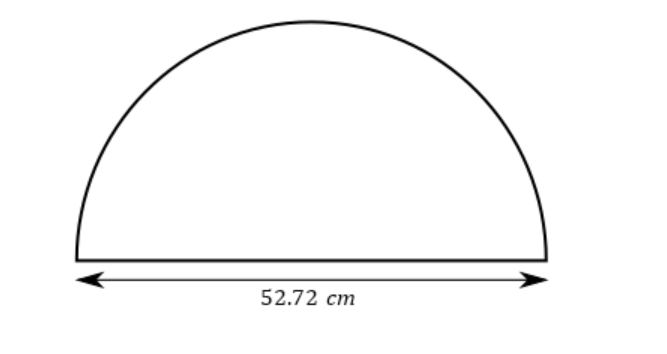

In [ ]:
#402
print(ds[2006]['problem_index'])
ds[2006]['image']

437


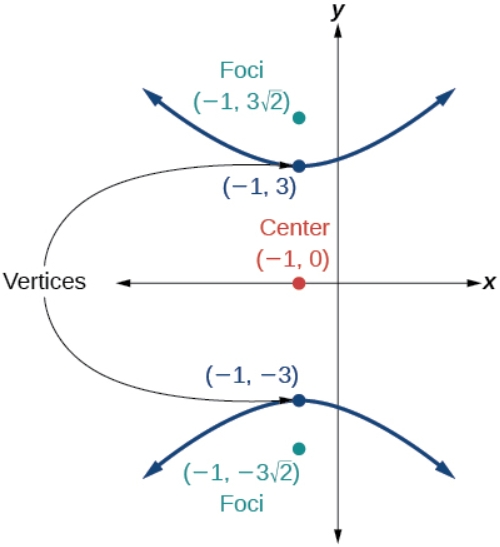

In [ ]:
#437
print(ds[2183]['problem_index'])
ds[2183]['image']

440


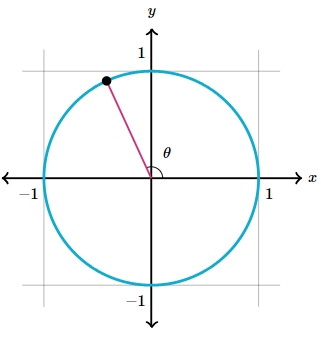

In [ ]:
#440
print(ds[2197]['problem_index'])
ds[2197]['image']

523


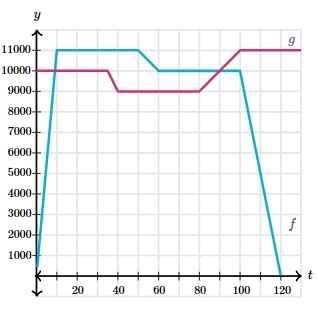

In [ ]:
#523
print(ds[2613]['problem_index'])
ds[2613]['image']

525


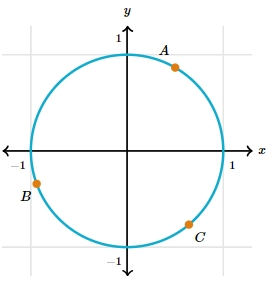

In [ ]:
#525
print(ds[2623]['problem_index'])
ds[2623]['image']

579


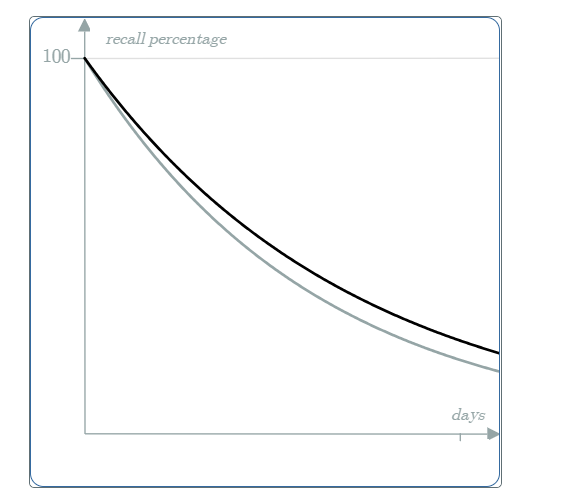

In [ ]:
#579
print(ds[2892]['problem_index'])
ds[2892]['image']

588


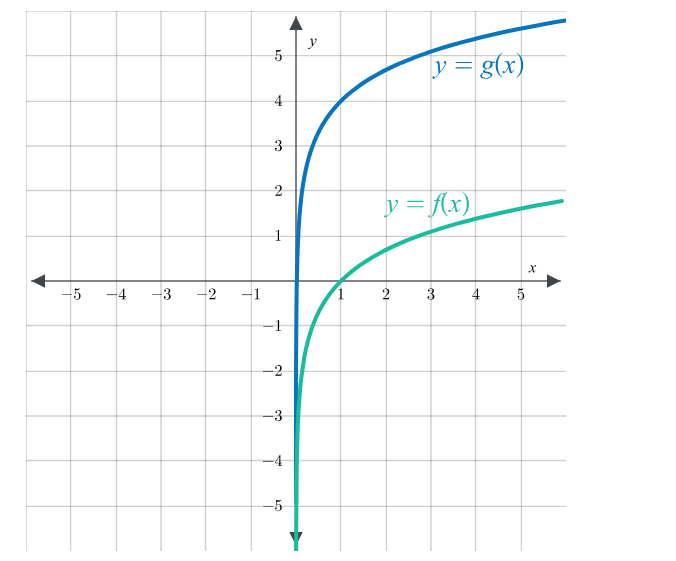

In [ ]:
#588
print(ds[2937]['problem_index'])
ds[2937]['image']

642


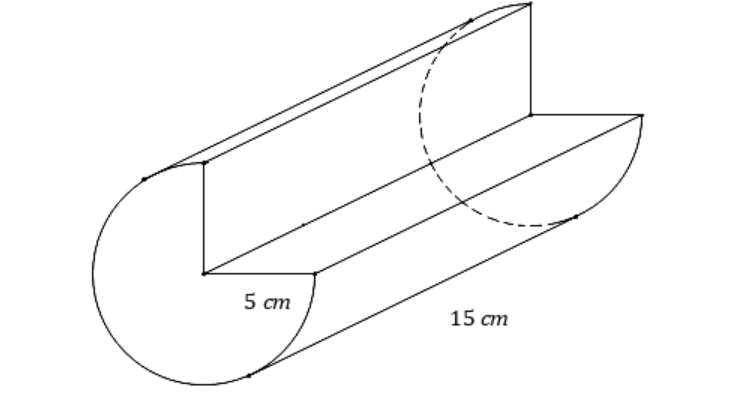

In [ ]:
#642
print(ds[3208]['problem_index'])
ds[3208]['image']

In [ ]:
from datasets import load_dataset

# 데이터셋 로드
dataset = load_dataset("AI4Math/MathVerse", 'testmini')

# 데이터프레임으로 변환
ds = dataset['testmini']

images = [ds[2613]['image'], ds[3292]['image'], ds[3208]['image'], ds[2937]['image'],ds[463]['image'],
          ds[1653]['image'],ds[1992]['image'],ds[3605]['image'],ds[1656]['image'],ds[2006]['image'],
          ds[2623]['image'],ds[3305]['image'], ds[2892]['image'],ds[1692]['image'], ds[2197]['image'],ds[2183]['image']]

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=317x311 at 0x7A5B49E90310>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=525x422 at 0x7A5B49E92890>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=755x416 at 0x7A5B49E90A90>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=676x561 at 0x7A5998583760>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=259x209 at 0x7A599B134580>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=279x350 at 0x7A599B136E90>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=520x357 at 0x7A599B134370>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=462x226 at 0x7A599B136B90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=229x336 at 0x7A599B136200>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=667x354 at 0x7A599B1376A0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=271x281 at 0x7A599B137010>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=789x615 at 0x7A599B134D60>, <PIL.PngImagePlugi

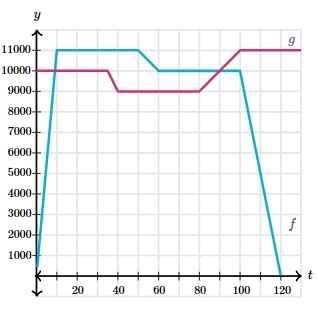

In [ ]:
print(images)
images[0]

In [ ]:
import re

image_folder = '/content/drive/MyDrive/few_imgs/'


image_filenames = ['image_523.png', 'image_659.png', 'image_642.png','image_588.png','image_93.png','image_331.png','image_399.png','image_722.png','image_332.png','image_402.png','image_525.png','image_662.png','image_579.png','image_339.png','image_440.png','image_437.png']  # 16개의 이미지 파일 이름
# 이미지를 불러오고 PIL Image 객체로 변환
example_images = [Image.open(os.path.join(image_folder, img_name)).convert('RGB') for img_name in image_filenames]


def evaluate_Idefics2(dataset, batch_size=16):
    true_labels = []
    pred_labels = []

    keys = list(dataset.keys())

    for i in range(0, len(dataset), batch_size):  #key로 계산

        batch = {key: dataset[key][i: i + batch_size] for key in keys}

        for j in range(len(batch[next(iter(batch))])):
        #배치 길이 계산 루프 부분 수정됨
            data = {key: batch[key][j] for key in keys}

            if "answer" not in data:
                continue

            question = data["query_cot"]
            answer = str(data["answer"])
            true_labels.append(answer)

            current_prompt = prompt[i + j]
            current_image

            prompt_text = current_prompt + f"Q: {question}\nA:"

            prompt_text_with_image = prompt_text.replace("{question}", "<image> {question}")
            inputs = processor(text=prompt_text_with_image, images=dataset['image'][i + j], return_tensors="pt")

            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                output_ids = model.generate(**inputs, max_new_tokens=500)

            #output_text가 str인지 확인
            output_text = processor.decode(output_ids[0], skip_special_tokens=True)
            if not isinstance(output_text, str):
                output_text = output_text.decode('utf-8')  # decoding

            def extract_answer(output_text):
                #정규식 사용) The answer is 뒤의 answer axtaction 수행
                pattern = r"The answer is[:]*\s*([^\n]*)"

                #matches 지정
                matches = re.findall(pattern, output_text, re.DOTALL)

                if matches:
                    #matches의 맨 끝에서 가져옴
                    answer = matches[-1].strip()
                    return answer
                else:
                    return None

            generated_answer = extract_answer(output_text)
            pred_labels.append(generated_answer)

            print(f"Question: {' '.join(question.splitlines())}")
            print(f"Output Text: {output_text}")
            print(f"Generated Answer: {generated_answer}")
            print(f"True Answer: {answer}")
            print("---")

            del inputs
            del output_ids
            torch.cuda.empty_cache()

    pred_labels = [ans if ans is not None else "" for ans in pred_labels]

    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    return accuracy, f1, precision, recall

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-07-29 05:28:03.294689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 05:28:03.294739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 05:28:03.296167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread